# Artificial Intelligence
# 464/664
# Assignment #6

## General Directions for this Assignment

00. We're using a Jupyter Notebook environment (tutorial available here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html),
01. Read the entire notebook before beginning your work, 
02. Output format should be exactly as requested (it is your responsibility to make sure notebook looks as expected on Gradescope),
03. Each helper function should be preceeded by documentation (Markdown cell),
04. No comments in the code; anything worth mentioning should be included in the documentation,
05. Use descriptive variable names,
06. Functions should do only one thing,
07. Check submission deadline on Gradescope, 
08. Rename the file to Last_First_assignment_6, 
09. Submit your notebook (as .ipynb, not PDF) using Gradescope, 
10. Do not submit any other files, and
11. **Do not use any AI/ML libraries, packages, such as pandas, scikit (numpy is fine)**

## Directions _not_ applicable for this Assignment:
* Do not use classes,
* Keep functions to 20 lines or less (including empty lines so do not add any),
* Each helper function should be followed by three assert-style unit tests.

## Before You Submit...

1. Re-read the general instructions provided above, and
2. Hit "Kernel"->"Restart & Run All".

## Decision Trees

For this assignment we will implement a Decision Tree using the ID3 Algorithm. The goal is classify a mushroom as either edible ('e') or poisonous ('p'). Dataset has been uploaded to Canvas. In case you'd like to learn more about it, here's the link to the repo: https://archive.ics.uci.edu/dataset/73/mushroom. 


Our  Decision Tree pipeline is as follows:


1) `cross_validate` will take data (supplied as folds using 10 fold cross validation) and do the following:
* For each setting of depth limit (the hyperparameter in decision trees, including 0)
* * and for each fold of data
* * * use `create_train_test` to split current fold into train and test
* * * call `train` to build and return a decision tree, 
* * * call `classify` to use the tree to get classifications,
* * * call `evaluate` to compare classifications to the actual answers (ground truth),
* * * Print the performance for that fold
* * Summarize the performance for that depth limit over all folds using `get_stats`


2) `pretty_print_tree(tree)` will print what the tree looks like when using the **entire** data set (no train/test split) with depth limit set to None.


All the code in this pipeline has been provided, except for a working `train` function. The `train` function currently returns a hard-coded tree from our lecture. Don't do that. Use ID3 to build your tree and use the depth limit to stop. When you're train function is complete, it should work for the lecture data, and mushrooms. Although `train` is terrible right now, pay attention to how the tree is structured.

In [1]:
import random
import math
import copy
from copy import deepcopy
from typing import List, Dict, Tuple, Callable
import numpy as np

<a id="note"></a>

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>
        Let's start with our example from the 06-Nov lecture. Target variable is Safe?, which can be yes or no. Anything *_lecture refers to the dataset we walked through in class.  
    </p>
</div>

In [2]:
data_lecture = [['round','large','blue','no'],
['square','large','green','yes'],
['square','small','red','no'],
['round','large','red','yes'],
['square','small','blue','no'],
['round','small','blue','no'],
['round','small','red','yes'],
['square','small','green','no'],
['round','large','green','yes'],
['square','large','green','yes'],
['square','large','red','no'],
['square','large','green','yes'],
['round','large','red','yes'],
['square','small','red','no'],
['round','small','green','no']]

In [3]:
print(data_lecture[0]) # a record of data

['round', 'large', 'blue', 'no']


In [4]:
len(data_lecture)

15

In [5]:
attribute_names_lecture = ['shape', 
                      'size', 
                      'color']

<a id="create_folds"></a>
## create_folds


With n-fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. For data set with 100 observations (or records), n set to 10 would have 10 observations in each fold.

* **data** List: a list (data_lecture, for instance)
* **n** int: number of folds


**returns** 
folds, which is a list of n items, where each item is a list containing a subgroup of xs

In [6]:
def create_folds(data: List, n: int) -> List[List[List]]:
    k, m = divmod(len(data), n)
    return list(data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds_lecture = create_folds(data=data_lecture, n=10)

In [8]:
len(folds_lecture)

10

In [9]:
print(folds_lecture[0])

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes']]


In [10]:
print(folds_lecture[1])

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes']]


<a id="create_train_test"></a>
## create_train_test


This function takes the n folds and returns the train and test sets. One of the n folds is used to test, the others are used for training.

* **folds** List[List[List]]: see `create_folds`
* **index** int: fold index that is used for testing


**returns** 
folds, which is a list of n items, where each item is a list containing a subgroup of xs

In [11]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

In [12]:
train_lecture, test_lecture = create_train_test(folds_lecture, 0) # test data is folds_lecture index 0

In [13]:
print(train_lecture)

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'blue', 'no'], ['round', 'small', 'blue', 'no'], ['round', 'small', 'red', 'yes'], ['square', 'small', 'green', 'no'], ['round', 'large', 'green', 'yes'], ['square', 'large', 'green', 'yes'], ['square', 'large', 'red', 'no'], ['square', 'large', 'green', 'yes'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'red', 'no'], ['round', 'small', 'green', 'no']]


In [14]:
print(test_lecture)

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes']]


In [15]:
train_lecture, test_lecture = create_train_test(folds_lecture, 1) # test data is folds_lecture index 1

In [16]:
print(train_lecture)

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes'], ['square', 'small', 'blue', 'no'], ['round', 'small', 'blue', 'no'], ['round', 'small', 'red', 'yes'], ['square', 'small', 'green', 'no'], ['round', 'large', 'green', 'yes'], ['square', 'large', 'green', 'yes'], ['square', 'large', 'red', 'no'], ['square', 'large', 'green', 'yes'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'red', 'no'], ['round', 'small', 'green', 'no']]


In [17]:
print(test_lecture)

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes']]


<a id="note"></a>

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's load the mushroom data.
    </p>
</div>

<a id="parse_data"></a>
## parse_data

Opens a file, splits on comma, and shuffles data before returning as a List of list. 

* **file_name** Str: filename for data


**returns** 
Data as a list of a list.

In [18]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [value for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [19]:
data_mushroom = parse_data("agaricus-lepiota.data")

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Important</strong>
    <p>
        We're going to move the target column (mushroom edible or poisonous) to the last column to match the lecture's format, where Safe? was at the end.
    </p>
</div>

In [20]:
data_mushroom = [record[1:]+[record[0]] for record in data_mushroom]

In [21]:
len(data_mushroom)

8124

In [22]:
print(data_mushroom[0])

['x', 'y', 'n', 't', 'n', 'f', 'c', 'b', 'n', 't', 'b', 's', 's', 'w', 'w', 'p', 'w', 'o', 'p', 'n', 'v', 'd', 'e']


In [23]:
attribute_names_mushroom = ['cap-shape',
                   'cap-surface',
                   'cap-color',
                   'bruises?',
                   'odor',
                   'gill-attachment',
                   'gill-spacing',
                   'gill-size',
                   'gill-color',
                   'stalk-shape',
                   'stalk-root',
                   'stalk-surface-above-ring',
                   'stalk-surface-below-ring',
                   'stalk-color-above-ring',
                   'stalk-color-below-ring',
                   'veil-type',
                   'veil-color',
                   'ring-number',
                   'ring-type',
                   'spore-print-color',
                   'population',
                   'habitat']

## Node

The `Node` class represents a node in a tree structure, designed for applications such as decision trees or hierarchical structures. Each node can have a title, depth, attribute index (for decision-making processes), and child nodes. Nodes can also be identified as leaf nodes.

### Parameters:
* **title** `str`: The title or label for the node.
* **depth** `int`: The depth of the node in the tree (e.g., root node depth is 0).
* **attribute_index** `int` (optional): The index of the attribute associated with this node for decision-making purposes. Defaults to `None` if not specified.
* **is_leaf** `bool` (optional): Indicates whether the node is a leaf node (i.e., has no children). Defaults to `False`.

### Attributes:
* **__title** `str`: The title or label of the node.
* **__depth** `int`: The depth of the node in the tree.
* **__attribute_index** `int or None`: The index of the attribute associated with this node, used for decision-making.
* **__is_leaf** `bool`: A flag indicating if the node is a leaf.
* **__parent** `Node or None`: The parent node of this node. Defaults to `None`.
* **__children** `Dict`: A dictionary mapping child values to child `Node` objects.

### Methods:

---

<a id="is_leaf"></a>
### `is_leaf()`

Checks if the node is a leaf node (i.e., has no children).

**returns** `bool`: `True` if the node is a leaf node; `False` otherwise.

---

<a id="get_title"></a>
### `get_title()`

Returns the title or label of the node.

**returns** `str`: The title of the node.

---

<a id="get_attribute_index"></a>
### `get_attribute_index()`

Returns the attribute index associated with the node.

**returns** `int or None`: The attribute index of the node, or `None` if not set.

---

<a id="get_children"></a>
### `get_children()`

Returns the child nodes of the current node as a list of key-value pairs, where the key is the value used to branch to the child node, and the value is the child `Node` object.

**returns** `dict_items`: A view of the child nodes as key-value pairs.

---

<a id="set_parent"></a>
### `set_parent(node)`

Sets the parent node of the current node.

* **node** `Node`: The node to be set as the parent.

**returns** None.

---

<a id="set_child"></a>
### `set_child(value, node)`

Sets a child node for the current node, using a value as the key to branch to this child.

* **value** `Any`: The value used to determine which branch leads to the child node.
* **node** `Node`: The child node to be added.

**returns** None.


In [24]:
class Node:
    
    def __init__(self, title, depth, attribute_index=None, is_leaf=False):
        self.__title = title
        self.__depth = depth
        self.__attribute_index = attribute_index
        self.__is_leaf = is_leaf
        self.__parent = None
        self.__children = {}
        
    def is_leaf(self):
        return self.__is_leaf
    
    def get_title(self):
        return self.__title
    
    def get_attribute_index(self):
        return self.__attribute_index
    
    def get_children(self):
        return self.__children.items()
        
    def set_parent(self, node):
        self.__parent = node
        
    def set_child(self, value, node):
        self.__children[value] = node

<a id="get_answers"></a>
## get_answers

This function extracts a list of the target values from data. The function assumes the target variable is the last column of the data.

* **data** List[List]: The data provided in a list of list format identical to the structure of `data_lecture` or `data_mushroom`


**returns** 
A list of the values of the target variable.

In [25]:
def get_answers(data):
    return [record[-1] for record in data]

In [26]:
assert get_answers([]) == []
assert get_answers(data_lecture) == ['no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no']

<a id="get_mode"></a>
## get_mode

This function finds the mode of a list of items. 

* **answers** List: A list of items

**returns** 
The item that appears the most often in the list. 

In [27]:
def get_mode(answers):
    count_dict = {}
    for answer in answers:
        if answer in count_dict:
            count_dict[answer] = count_dict[answer] + 1
        else:
            count_dict[answer] = 1
    mode_count = max(count_dict.values())
    mode = [k for k, v in count_dict.items() if v == mode_count]
    return mode[0]

In [28]:
assert get_mode(['no', 'no', 'no', 'yes']) == 'no'
assert get_mode(['no', 'no', 'yes', 'yes']) == 'no'
assert get_mode(['no', 'yes', 'yes', 'yes']) == 'yes'

<a id="get_structured_data"></a>
## get_structured_data

This function converts a 2D list or array of raw data into a structured numpy array, where each column is labeled with a corresponding feature name.

* **data** `List[List]` or `np.ndarray`: The raw data, where each inner list or row represents a data sample with feature values.
* **feature_names** `List[str]`: A list of feature names corresponding to the columns of `data`. The function will append 'y' as the name of the target variable automatically.

**returns** 
* **structured_data** `np.ndarray`: A structured numpy array with each element labeled by the feature names and the target variable `y`.

The function creates a structured array by mapping each row of the input data to a tuple and defining the data type for each column using the provided feature names plus the target variable `y`. Each feature and the target are represented as a string with a single Unicode character (`'U16'` data type).


In [29]:
def get_structured_data(data, feature_names):
    return np.array([tuple(data_sample) for data_sample in data], dtype=[(name, 'U16') for name in (feature_names + [('y')])])

<a id="calculate_entropy"></a>
## calculate_entropy

This function calculates the entropy of a dataset, which is a measure of the uncertainty or impurity in the dataset.

* **counts** `np.ndarray`: An array representing the counts of each unique value in the target variable or subset of the data.
* **length** `int`: The total number of observations in the dataset or subset of the data.

**returns** 
* **entropy** `float`: The calculated entropy value based on the given counts and total number of observations.

The function computes the entropy by first calculating the proportion of each count relative to the total number of observations. It then iterates through these proportions, accumulating the entropy using the formula \( -\sum p(x) \log_2 p(x) \), where \( p(x) \) is the proportion of each unique value.


In [30]:
def calculate_entropy(counts, length):
    proportions = counts / length
    entropy = 0
    for proportion in proportions:
        entropy -= proportion * np.log2(proportion)
    return entropy

<a id="calculate_information_gain"></a>
## calculate_information_gain

This function calculates the information gain of a given attribute in a dataset. Information gain measures the reduction in entropy achieved by partitioning the data based on an attribute.

* **data** `np.ndarray`: A structured numpy array representing the dataset, including both features and the target variable `y`.
* **attribute_name** `str`: The name of the attribute/feature in the dataset for which the information gain is being calculated.
* **baseline_entropy** `float`: The entropy of the entire dataset (before partitioning).

**returns** 
* **information_gain** `float`: The calculated information gain after partitioning the dataset based on the specified attribute.

The function works by iterating through each unique value of the given attribute, calculating the entropy for each subset of data where the attribute takes that value, and computing a weighted average of those entropies. The final result is the difference between the baseline entropy and the weighted average, representing the information gain.


In [31]:
def calculate_information_gain(data, attribute_name, baseline_entropy):
    values, counts = np.unique(data[attribute_name], return_counts=True)
    counts_dict = dict(zip(values, counts))
    entropies = {}
    
    for value in values:
        mask = data[attribute_name] == value
        selected_targets = data['y'][mask]
        targets, target_counts = np.unique(selected_targets, return_counts=True)
        entropies[value] = calculate_entropy(target_counts, counts_dict[value])
        
    weighted_average = 0
    for value, entropy in entropies.items():
        weight = counts_dict[value] / len(data[attribute_name])
        weighted_average += weight * entropy
    
    return baseline_entropy - weighted_average

<a id="pick_best_attribute"></a>
## pick_best_attribute

This function selects the best attribute for splitting the data by calculating the information gain for each attribute and returning the attribute with the highest information gain.

* **data** `np.ndarray`: A structured numpy array representing the dataset, including both features and the target variable `y`.
* **attributes** `List[str]`: A list of attribute names to be evaluated for information gain.

**returns** 
* **best_attribute** `str`: The name of the attribute with the highest information gain.

The function first calculates the baseline entropy of the target variable `y` in the dataset. It then iterates over each attribute provided in `attributes`, calculating the information gain for each one using `calculate_information_gain()`. Finally, it returns the attribute that yields the highest information gain.


In [32]:
def pick_best_attribute(data, attributes):
    values, counts = np.unique(data['y'], return_counts=True)
    baseline_entropy = calculate_entropy(counts, len(data['y']))
    
    information_gains = {}
    for attribute_name in attributes:
        information_gains[attribute_name] = calculate_information_gain(data, attribute_name, baseline_entropy)
    
    return max(information_gains, key=information_gains.get)

<a id="data_is_homogeneous"></a>
## data_is_homogeneous

This function checks whether the target variable `y` in a given dataset is homogeneous, i.e., all target values are the same.

* **data** `np.ndarray`: A structured numpy array representing the dataset, which includes the target variable `y`.

**returns** 
* **is_homogeneous** `bool`: `True` if the data is homogeneous (i.e., all target values are the same), otherwise `False`.

The function calculates the entropy of the target variable `y` using `calculate_entropy()`. If the entropy is zero, it means there is no uncertainty, indicating that the data is homogeneous. An assertion is included to ensure the input dataset is not empty.


In [33]:
def data_is_homogeneous(data):
    assert len(data['y']) > 0
    values, counts = np.unique(data['y'], return_counts=True)
    baseline_entropy = calculate_entropy(counts, len(data['y']))
    return baseline_entropy == 0

<a id="get_values"></a>
## get_values

This function retrieves the unique values for a specified attribute in the dataset, excluding any missing or placeholder values (e.g., '?').

* **data** `np.ndarray`: A structured numpy array representing the dataset.
* **attribute_name** `str`: The name of the attribute for which unique values are to be retrieved.

**returns** 
* **values** `np.ndarray`: An array of unique values for the specified attribute, with any placeholder values (e.g., '?') excluded.

The function uses `np.unique()` to find the unique values in the specified attribute and filters out any values that are equal to the placeholder character (`'?'`).


In [34]:
def get_values(data, attribute_name):
    values = np.unique(data[attribute_name])
    return values[values != '?']

<a id="get_subset_with_attribute_value"></a>
## get_subset_with_attribute_value

This function extracts a subset of the dataset where the specified attribute has a given value.

* **data** `np.ndarray`: A structured numpy array representing the dataset.
* **attribute_name** `str`: The name of the attribute used to filter the data.
* **value** `str` or `any`: The value of the attribute that should be matched in the subset.

**returns** 
* **subset** `np.ndarray`: A structured numpy array containing only the rows where the specified attribute has the given value.

The function creates a mask by comparing the specified attribute to the given value and applies it to the dataset to return the filtered subset.


In [35]:
def get_subset_with_attribute_value(data, attribute_name, value):
    mask = data[attribute_name] == value
    return data[mask]

<a id="dictionaried_tree"></a>
## dictionaried_tree

This function converts a decision tree represented by `Node` objects into a nested dictionary structure for easier interpretation and visualization.

* **node** `Node`: The root `Node` object of the decision tree.

**returns** 
* **tree_dict** `Dict`: A nested dictionary representation of the decision tree. Each key in the dictionary is a tuple of the form `(attribute_name, attribute_index, attribute_value)`, and the corresponding value is either another nested dictionary or a label if the node is a leaf.

The function recursively traverses the tree, converting each non-leaf `Node` into a dictionary where the keys represent the attribute and its corresponding value, and the values are either sub-trees or the final labels for leaf nodes.


In [36]:
def dictionaried_tree(node):
    if node.is_leaf(): return node.get_title()
    dictionary = {}
    for value, child in node.get_children():
        dictionary[(node.get_title(), node.get_attribute_index(), value)] = dictionaried_tree(child)
    return dictionary

<a id="print_nested_dict"></a>
## print_nested_dict

This function prints a nested dictionary in a formatted and indented style for better readability.

* **d** `Dict`: The nested dictionary to be printed.
* **indent** `int`: The number of spaces for indentation (used for recursive calls). Defaults to 0.
* **is_first_level** `bool`: A flag indicating whether the current level is the top level of the dictionary. Defaults to `True`.

**returns** 
* None: This function prints the formatted nested dictionary directly to the console.

The function recursively traverses the nested dictionary, printing keys and values with appropriate indentation. If a value is another dictionary, it calls itself to print the nested structure. This creates a human-readable output that helps visualize complex dictionary structures.


In [37]:
def print_nested_dict(d, indent=0, is_first_level=True):
    if is_first_level:
        print(' ' * indent + '{')
    else:
        print(' {', end='')

    first = True
    for key, value in d.items():
        if not first:
            print(',', end='')
        first = False
        print()
        print(' ' * (indent + 4) + repr(key) + ': ', end='')
        if isinstance(value, dict):
            print_nested_dict(value, indent + 4, is_first_level=False)
        else:
            print(repr(value), end='')

    print()
    if is_first_level:
        print(' ' * indent + '}')
    else:
        print(' ' * indent + '}', end='')

<a id="id3"></a>
## id3

This function implements the ID3 (Iterative Dichotomiser 3) algorithm for training a decision tree based on a dataset and a set of attributes. The algorithm recursively selects the best attribute to split the data until certain stopping conditions are met.

* **data** `np.ndarray`: A structured numpy array representing the dataset, including features and the target variable `y`.
* **attributes** `List[str]`: A list of attribute names used for splitting the data.
* **default** `str` or `any`: The default label returned if the dataset is empty.
* **depth** `int`: The current depth of the tree.
* **depth_limit** `int` or `None`: An optional depth limit for the tree. If `None`, the tree can grow indefinitely; otherwise, the tree stops splitting when the limit is reached.

**returns** 
* **node** `Node`: A `Node` object representing the root of the trained decision tree or a subtree.

**Functionality**:
- **Base Cases**:
  - Returns a leaf `Node` with the `default` label if the dataset is empty.
  - Returns a leaf `Node` with the label of the first target value if the data is homogeneous (all `y` values are the same).
  - Returns a leaf `Node` with the mode of `y` if there are no more attributes to split on.
- **Recursive Step**:
  - Selects the best attribute to split the data using `pick_best_attribute()`.
  - Creates a `Node` for the chosen attribute.
  - Iterates over each unique value of the attribute, creating a subset of the data where the attribute matches the value.
  - Recursively calls `id3()` to build child nodes and sets them as children of the current `Node`.

The function builds the decision tree until a stopping condition is met or the optional `depth_limit` is reached. Each child node is linked to its parent, and the parent node holds references to all child nodes, forming the tree structure.


In [38]:
def id3(data, attributes, default, depth, depth_limit=None):
    
    if len(data) == 0: return Node(default, depth, is_leaf=True)
    if data_is_homogeneous(data): return Node(data['y'][0], depth, is_leaf=True)
    if len(attributes) == 0 or depth_limit == depth: return Node(get_mode(data['y']), depth, is_leaf=True)
    
    best_attribute = pick_best_attribute(data, attributes)
    
    all_attributes = np.array(data.dtype.names)
    attribute_index = np.where(all_attributes == best_attribute)[0][0]
    
    node = Node(best_attribute, depth, attribute_index=attribute_index)
    
    default_label = get_mode(data['y'])
    
    for value in get_values(data, best_attribute):
        subset = get_subset_with_attribute_value(data, best_attribute, value)
        child = id3(subset, [attribute for attribute in attributes if attribute != best_attribute], default_label, depth + 1, depth_limit)
        child.set_parent(node)
        node.set_child(value, child)
    
    return node

<a id="train"></a>
## train

This function takes training_data, attribute names, and the depth limit and returns the decision tree as a nested dictionary. If the depth is 0, a dictionary is not returned. Instead, the mode of the target values is returned (i.e., majority class). 

* **training_data** List[List]: The data
* **attribute_names** List: The attribute names of the data (22 for mushroom; size, shape, and color for the lecture)
* **depth_limit** int: The depth limit of the tree


**returns** 
* **dt** Dict: The trained decision tree using the ID3 algorithm (entropy, information gain). It is represented as a nested dictionary. The dictionary returned for the lecture is structured as below:

```
{
('size', 1, 'large'): 
    {('color', 2, 'blue'): 'no', 
     ('color', 2, 'green'): 'yes', 
     ('color', 2, 'red'): 
         {('shape', 0, 'round'): 'yes', 
          ('shape', 0, 'square'): 'no'}
     }, 
('size', 1, 'small'): 
     {('shape', 0, 'square'): 'no', 
      ('shape', 0, 'round'): 
          {('color', 2, 'blue'): 'no', 
           ('color', 2, 'red'): 'yes', 
           ('color', 2, 'green'): 'no'}
      }
}
```


Notice that the keys are tuples; for instance, ('size', 1, 'large') is a key. The key includes the attribute's name, column number in data, and value.


The function currently returns a hard-coded tree. Your implementation should replace this with a tree that is learned from the data using the ID3 algorithm. You do not have to assert test `train`, but it may be worthwhile to check that it can return the tree from the lecture once your implementation is in place.

In [39]:
def train(training_data, attribute_names, depth_limit=None):
    structured_data = get_structured_data(training_data, attribute_names)
    decision_tree_root = id3(structured_data, attribute_names, get_mode(structured_data['y']), 0, depth_limit)
    return dictionaried_tree(decision_tree_root)

In [40]:
dt_lecture = train(training_data=train_lecture, attribute_names=attribute_names_lecture, depth_limit=None)

<a id="get_prediction"></a>
## get_prediction

This recursive function uses a decision tree represented as a nested dictionary get a prediction from a record, which is a row of the data. 

* **record** List[]: A row of data to be predicted
* **dt** the decision tree used to make the prediction


**returns** 
A prediction ('yes' or 'no' for instance, from our Self Check example.) 

In [41]:
def get_prediction(record, dt):
    if not isinstance(dt, dict):
        return dt
    else:
        for key, value in dt.items():
            if record[key[1]]==key[2]:
                return get_prediction(record, value)

In [42]:
print(get_prediction(['round','large','blue','no'], dt=dt_lecture))
print(get_prediction(['square','large','green','yes'], dt=dt_lecture))
print(get_prediction(['square','small','red','no'], dt=dt_lecture))

no
yes
no


<a id="classify"></a>
## classify

This function takes a decision tree, observations, and a labeled flag to return a list of classifications. 

* **dt** Dict: The decision tree as a nested dictionary
* **observation** List[List]: a list of items, where each item is a row of the data
* **labeled** Bool: true for labeled data


**returns** 
* **y_hat** List: A list of classifications.

In [43]:
def classify(dt, observations):
    y_hat = []
    for record in observations:
        y_hat.append(get_prediction(record, dt))   
    return y_hat

In [44]:
print(classify(dt=dt_lecture, observations=test_lecture))

['no', 'yes']


<a id="evaluate"></a>
## evaluate

This function evaluates the performance of a classifier. It takes a data set (training set or test set) and the classification result (see [classify](#classify) above and calculates the classification error rate:

$$error\_rate=\frac{errors}{n}$$ 

* **y_hat** List: A list of predictions
* **observations** List[List]: Data to be predicted (typically training or test set)


**returns** 

* **error_rate** float: The error rate.

In [45]:
def evaluate(y_hat, observations):
    errors = 0
    ground_truth = get_answers(observations)
    for index in range(len(y_hat)):
        if y_hat[index] != ground_truth[index]:
            errors = errors + 1
    return errors / (len(y_hat))

In [46]:
print(evaluate(classify(dt=dt_lecture, observations=data_lecture), observations=data_lecture))

0.0


<a id="get_stats"></a>
## get_stats

This function computes the mean and the standard deviation for a given list of observations. 

* **observations** List[float]: A list of observations


**returns** (mean, standard deviation) Tuple[float,float]: tuple consisting of mean and the standard deviation

In [47]:
def get_stats(observations: List[float]) -> Tuple[float,float]:
    mean = sum(observations) / len(observations)
    variance = sum([(elem - mean)**2 for elem in observations]) / len(observations)
    std_dev = math.sqrt(variance)
    return mean, std_dev

In [48]:
assert get_stats([2, 4, 4, 4, 5, 5, 7, 9]) == (5.0, 2.0)
assert get_stats([1, 1, 1]) == (1.0, 0.0)
assert get_stats([0]) == (0.0, 0.0)

<a id="cross_validate"></a>
## cross_validate

This function takes folds of data to `train`, `classify`, and `evaluate`.


* **folds** List[List[List]]: The original dataset partitioned into folds (see `create_folds` above)
* **attribute_names** int: the feature names
* **hyperparameters** List: A list of hyperparameters to explore (depth limits for a decision tree, for instance)

**returns** 

Nothing is returned, but for each hyperparameter setting, the function prints out the fold number and the error rate for that fold. The mean and variance is printed across folds for each hyperparameter setting. The error rates are reported in terms of percents.

In [49]:
def cross_validate(folds, attribute_names, hyperparameters):
    for hyperparameter in hyperparameters:
        train_error, test_error  = [], []
        error_list_train, error_list_test = [], []
        for fold_index in range(len(folds)):
            training_data, test_data = create_train_test(folds, fold_index)
            tree = train(training_data=training_data, attribute_names=attribute_names, depth_limit=hyperparameter)
            y_hat_train = classify(tree, training_data)
            y_hat_test = classify(tree, test_data)
            error_rate_train = evaluate(y_hat_train, training_data)
            error_rate_test = evaluate(y_hat_test, test_data)
            error_list_train.append(error_rate_train)
            error_list_test.append(error_rate_test)
            print(f"Fold: {fold_index}\tTrain Error: {error_rate_train*100:.2f}%\tTest Error: {error_rate_test*100:.2f}%")
        print(f"***")
        print(f"Depth limit: {hyperparameter}")
        print(f"\nMean(Std. Dev.) over all folds:\n-------------------------------")
        print(f"Train Error: {get_stats(error_list_train)[0]*100:.2f}%({get_stats(error_list_train)[1]*100:.2f}%) Test Error: {get_stats(error_list_test)[0]*100:.2f}%({get_stats(error_list_test)[1]*100:.2f}%)")
        print("\n")

In [50]:
cross_validate(folds=folds_lecture, attribute_names=attribute_names_lecture, hyperparameters=[0, 1, 2, 3, 4, 5, None])

Fold: 0	Train Error: 46.15%	Test Error: 50.00%
Fold: 1	Train Error: 46.15%	Test Error: 50.00%
Fold: 2	Train Error: 46.15%	Test Error: 100.00%
Fold: 3	Train Error: 46.15%	Test Error: 50.00%
Fold: 4	Train Error: 38.46%	Test Error: 100.00%
Fold: 5	Train Error: 50.00%	Test Error: 0.00%
Fold: 6	Train Error: 42.86%	Test Error: 100.00%
Fold: 7	Train Error: 42.86%	Test Error: 100.00%
Fold: 8	Train Error: 50.00%	Test Error: 0.00%
Fold: 9	Train Error: 50.00%	Test Error: 0.00%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 45.88%(3.53%) Test Error: 55.00%(41.53%)


Fold: 0	Train Error: 15.38%	Test Error: 50.00%
Fold: 1	Train Error: 30.77%	Test Error: 50.00%
Fold: 2	Train Error: 23.08%	Test Error: 0.00%
Fold: 3	Train Error: 15.38%	Test Error: 50.00%
Fold: 4	Train Error: 23.08%	Test Error: 0.00%
Fold: 5	Train Error: 14.29%	Test Error: 100.00%
Fold: 6	Train Error: 21.43%	Test Error: 0.00%
Fold: 7	Train Error: 21.43%	Test Error: 0.00%
Fold: 8	Train Er

<a id="pretty_print_tree"></a>
## pretty_print_tree

This function provides a text-based representation of a decision tree that is represented as a nested dictionary. 

* **dt** Dict: The decision tree as a nested dictionary
* **tab_space** Int: How much to tab successive depth levels of the resulting tree

In [51]:
def pretty_print_tree(dt, tab_space):
    for key, value in dt.items():
        if isinstance(value, dict):
            print("  " * tab_space + str(key[0]).upper() + " - " + str(key[2]) + ": ")
            print("\n")
            pretty_print_tree(value, tab_space+3)
        else:
            print("  " * tab_space + str(key[0]).upper() + " - " + str(key[2]) + " =====> " + str(value))
            print("\n")

In [52]:
dt_lecture = train(training_data=data_lecture, attribute_names=attribute_names_lecture, depth_limit=None)
pretty_print_tree(dt_lecture, tab_space=0)

SIZE - large: 


      COLOR - blue =====> no


      COLOR - green =====> yes


      COLOR - red: 


            SHAPE - round =====> yes


            SHAPE - square =====> no


SIZE - small: 


      SHAPE - round: 


            COLOR - blue =====> no


            COLOR - green =====> no


            COLOR - red =====> yes


      SHAPE - square =====> no




<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's work on the mushroom data. 
    </p>
</div>

## Classify the Mushrooom data

In [53]:
folds_mushroom = create_folds(data=data_mushroom, n=10)

In [54]:
cross_validate(folds=folds_mushroom, attribute_names=attribute_names_mushroom, hyperparameters=[0, 1, 2, 3, 4, 5, None])

Fold: 0	Train Error: 48.22%	Test Error: 48.09%
Fold: 1	Train Error: 47.97%	Test Error: 50.31%
Fold: 2	Train Error: 48.32%	Test Error: 47.11%
Fold: 3	Train Error: 48.20%	Test Error: 48.22%
Fold: 4	Train Error: 48.22%	Test Error: 48.03%
Fold: 5	Train Error: 48.43%	Test Error: 46.18%
Fold: 6	Train Error: 47.93%	Test Error: 50.62%
Fold: 7	Train Error: 48.06%	Test Error: 49.51%
Fold: 8	Train Error: 48.45%	Test Error: 45.94%
Fold: 9	Train Error: 48.22%	Test Error: 48.03%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 48.20%(0.17%) Test Error: 48.20%(1.50%)


Fold: 0	Train Error: 1.52%	Test Error: 1.11%
Fold: 1	Train Error: 1.42%	Test Error: 1.97%
Fold: 2	Train Error: 1.53%	Test Error: 0.98%
Fold: 3	Train Error: 1.52%	Test Error: 1.11%
Fold: 4	Train Error: 1.48%	Test Error: 1.48%
Fold: 5	Train Error: 1.44%	Test Error: 1.85%
Fold: 6	Train Error: 1.42%	Test Error: 1.97%
Fold: 7	Train Error: 1.50%	Test Error: 1.23%
Fold: 8	Train Error: 1.49%	Test

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's work on the mushroom data. 
    </p>
</div>

## Print the Mushroom Tree

In [55]:
dt_mushroom = train(training_data=data_mushroom, attribute_names=attribute_names_mushroom, depth_limit=None)
pretty_print_tree(dt_mushroom, tab_space=0)

ODOR - a =====> e


ODOR - c =====> p


ODOR - f =====> p


ODOR - l =====> e


ODOR - m =====> p


ODOR - n: 


      SPORE-PRINT-COLOR - b =====> e


      SPORE-PRINT-COLOR - h =====> e


      SPORE-PRINT-COLOR - k =====> e


      SPORE-PRINT-COLOR - n =====> e


      SPORE-PRINT-COLOR - o =====> e


      SPORE-PRINT-COLOR - r =====> p


      SPORE-PRINT-COLOR - w: 


            HABITAT - d: 


                  GILL-SIZE - b =====> e


                  GILL-SIZE - n =====> p


            HABITAT - g =====> e


            HABITAT - l: 


                  CAP-COLOR - c =====> e


                  CAP-COLOR - n =====> e


                  CAP-COLOR - w =====> p


                  CAP-COLOR - y =====> p


            HABITAT - p =====> e


            HABITAT - w =====> e


      SPORE-PRINT-COLOR - y =====> e


ODOR - p =====> p


ODOR - s =====> p


ODOR - y =====> p




## OPTIONAL. BONUS. 

Use an AI/ML library to build a decision tree for the mushroom dataset. Explore different depth limits. Print results. Display the best tree using your chosen library.  

<a id="gather_data"></a>
## gather_data

This function separates the features and the target variable from a pandas DataFrame.

* **dataframe** `pd.DataFrame`: A DataFrame containing the features and the target variable `y`.

**returns** 
* **features** `np.ndarray`: A 2D numpy array containing the feature values.
* **target** `np.ndarray`: A 1D numpy array containing the target values.


In [56]:
def gather_data(dataframe):
    target = dataframe.pop('y')
    return dataframe.values, target.values

<a id="preprocess_data"></a>
## preprocess_data

This function preprocesses data by applying one-hot encoding based on specified categories.

* **data** `np.ndarray`: The input data to be encoded. Can be a 1D or 2D array.
* **categories** `List[List[str]]`: A list of categories for each feature in the data.

**returns** 
* **encoded_data** `np.ndarray`: A 2D numpy array with one-hot encoded data.
* **encoder** `OneHotEncoder`: The fitted `OneHotEncoder` instance.


In [57]:
def preprocess_data(data, categories):
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    enc = OneHotEncoder(handle_unknown='ignore',
                    categories=categories,
                   sparse_output=False)
    enc.fit(data)
    return enc.transform(data), enc

<a id="postprocess_data"></a>
## postprocess_data

This function decodes one-hot encoded data back to its original categorical form.

* **data** `np.ndarray`: The one-hot encoded data to be decoded.
* **encoder** `OneHotEncoder`: The fitted `OneHotEncoder` used to decode the data.

**returns** 
* **decoded_data** `np.ndarray`: The decoded categorical data. If the original data was 1D, the returned array is flattened.


In [58]:
def postprocess_data(data, encoder):
    decoded_data = encoder.inverse_transform(data)
    if len(decoded_data) > 0 and len(decoded_data[0]) == 1:
        decoded_data = decoded_data.flatten()
    return decoded_data

<a id="cross_validate_sklearn"></a>
## cross_validate_sklearn

This function performs k-fold cross-validation on a dataset using a decision tree classifier with different depth limits or a majority-class predictor.

* **X** `np.ndarray`: Feature matrix for the dataset.
* **Y** `np.ndarray`: Target variable array for the dataset.
* **hyperparameters** `List[int]`: A list of depth limits for the decision tree classifier. A value of `0` applies a majority-class predictor.

**returns** 
* **clf** `DecisionTreeClassifier` or `None`: The trained classifier corresponding to the last hyperparameter used.


In [59]:
def cross_validate_sklearn(X, Y, hyperparameters):
    clf = None
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for hyperparameter in hyperparameters:
        train_errors = []
        test_errors = []
        fold_index = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            if hyperparameter == 0:
                from collections import Counter
                majority_class = Counter(Y_train).most_common(1)[0][0]
                Y_train_pred = np.full_like(Y_train, majority_class)
                Y_test_pred = np.full_like(Y_test, majority_class)
            else:
                clf = DecisionTreeClassifier(max_depth=hyperparameter)
                clf.fit(X_train, Y_train)
                Y_train_pred = clf.predict(X_train)
                Y_test_pred = clf.predict(X_test)
            train_error = np.mean(Y_train_pred != Y_train)
            test_error = np.mean(Y_test_pred != Y_test)
            train_errors.append(train_error)
            test_errors.append(test_error)
            print(f"Fold: {fold_index}\tTrain Error: {train_error*100:.2f}%\tTest Error: {test_error*100:.2f}%")
            fold_index +=1
        train_mean, train_std = get_stats(train_errors)
        test_mean, test_std = get_stats(test_errors)
        print(f"***")
        print(f"Depth limit: {hyperparameter}")
        print(f"\nMean(Std. Dev.) over all folds:\n-------------------------------")
        print(f"Train Error: {train_mean*100:.2f}%({train_std*100:.2f}%) Test Error: {test_mean*100:.2f}%({test_std*100:.2f}%)")
        print("\n")
    return clf

## Mushroom Data Classification Script

### Overview
This script performs the following tasks:

1. **Data Preparation**:
   - Reads the mushroom dataset from a CSV file (`agaricus-lepiota.data`).
   - Assigns column names, separating features and the target variable (`y`).

2. **Category Definitions**:
   - Defines the possible categories for each feature in the dataset, which are used for one-hot encoding.
   - Specifies `poisonous` as the target categories (`e` for edible, `p` for poisonous).

3. **Data Processing**:
   - Extracts features (`X`) and the target variable (`Y`) using the `gather_data` function.
   - Preprocesses the features (`X`) using one-hot encoding with the defined categories via the `preprocess_data` function.

4. **Cross-Validation**:
   - Defines a set of hyperparameters (depth limits) for a decision tree classifier.
   - Performs 10-fold cross-validation on the preprocessed dataset using the `cross_validate_sklearn` function. This includes:
     - Using a majority-class predictor when depth limit is 0.
     - Training decision tree classifiers for other depth limits.

5. **Visualization**:
   - If the best classifier (last trained) is a decision tree, it plots the tree structure using `matplotlib`.

---

### Key Insights
- The script combines preprocessing, cross-validation, and visualization to evaluate decision tree performance.
- Adjusting `hyperparameters` allows tuning the depth of the tree for optimal results.
- The one-hot encoding step ensures categorical features are properly handled for the decision tree model.

---

### Output
- Prints training and testing errors for each fold and depth limit during cross-validation.
- Displays a plot of the best-performing decision tree if applicable.


Fold: 0	Train Error: 48.37%	Test Error: 46.74%
Fold: 1	Train Error: 48.05%	Test Error: 49.57%
Fold: 2	Train Error: 48.11%	Test Error: 49.08%
Fold: 3	Train Error: 48.23%	Test Error: 47.97%
Fold: 4	Train Error: 48.02%	Test Error: 49.88%
Fold: 5	Train Error: 48.06%	Test Error: 49.51%
Fold: 6	Train Error: 48.03%	Test Error: 49.75%
Fold: 7	Train Error: 48.70%	Test Error: 43.72%
Fold: 8	Train Error: 48.13%	Test Error: 48.89%
Fold: 9	Train Error: 48.35%	Test Error: 46.92%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 48.20%(0.20%) Test Error: 48.20%(1.84%)


Fold: 0	Train Error: 11.34%	Test Error: 11.19%
Fold: 1	Train Error: 11.12%	Test Error: 13.16%
Fold: 2	Train Error: 11.16%	Test Error: 12.79%
Fold: 3	Train Error: 11.42%	Test Error: 10.46%
Fold: 4	Train Error: 11.26%	Test Error: 11.95%
Fold: 5	Train Error: 11.52%	Test Error: 9.61%
Fold: 6	Train Error: 11.42%	Test Error: 10.47%
Fold: 7	Train Error: 11.13%	Test Error: 13.05%
Fold: 8	Train Er

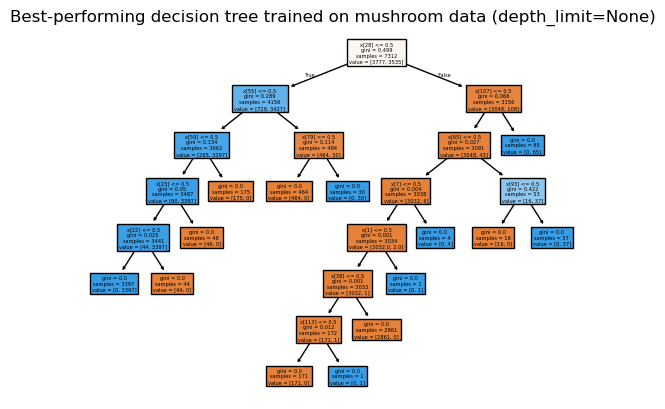

In [60]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

attribute_names_mushroom = ['cap-shape',
                            'cap-surface',
                            'cap-color',
                            'bruises?',
                            'odor',
                            'gill-attachment',
                            'gill-spacing',
                            'gill-size',
                            'gill-color',
                            'stalk-shape',
                            'stalk-root',
                            'stalk-surface-above-ring',
                            'stalk-surface-below-ring',
                            'stalk-color-above-ring',
                            'stalk-color-below-ring',
                            'veil-type',
                            'veil-color',
                            'ring-number',
                            'ring-type',
                            'spore-print-color',
                            'population',
                            'habitat']

data_mushroom = pd.read_csv('agaricus-lepiota.data', sep=',', header=None)
data_mushroom.columns = ['y'] + attribute_names_mushroom
target_column = data_mushroom.pop('y')
data_mushroom.insert(22, 'y', target_column)

cap_shape = ['b', 'c', 'x', 'f', 'k', 's']
cap_surface = ['f', 'g', 'y', 's']
cap_color = ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y']
bruises = ['t', 'f']
odor = ['a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's']
gill_attachment = ['a', 'd', 'f', 'n']
gill_spacing = ['c', 'w', 'd']
gill_size = ['b', 'n']
gill_color = ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y']
stalk_shape = ['e', 't']
stalk_root = ['b', 'c', 'u', 'e', 'z', 'r']
stalk_surface_above_ring = ['f', 'y', 'k', 's']
stalk_surface_below_ring = ['f', 'y', 'k', 's']
stalk_color_above_ring = ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y']
stalk_color_below_ring = ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y']
veil_type = ['p', 'u']
veil_color = ['n', 'o', 'w', 'y']
ring_number = ['n', 'o', 't']
ring_type = ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z']
spore_print_color = ['k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y']
population = ['a', 'c', 'n', 's', 'v', 'y']
habitat = ['g', 'l', 'm', 'p', 'u', 'w', 'd']
poisonous = ['e', 'p']

feature_categories_mushroom = [cap_shape, cap_surface, cap_color, bruises,\
                       odor, gill_attachment, gill_spacing, gill_size,\
                       gill_color, stalk_shape, stalk_root, stalk_surface_above_ring,\
                       stalk_surface_below_ring, stalk_color_above_ring, stalk_color_below_ring,\
                       veil_type, veil_color, ring_number, ring_type,\
                       spore_print_color, population, habitat]
target_categories_mushroom = [poisonous]

X, Y = gather_data(data_mushroom)

X_trans, X_enc = preprocess_data(X, feature_categories_mushroom)

hyperparameters = [0, 1, 2, 3, 4, 5, 6, 7, None]
classifier = cross_validate_sklearn(X_trans, Y, hyperparameters)

if not classifier == None:
    plt.figure()
    tree.plot_tree(classifier, filled=True)
    plt.title("Best-performing decision tree trained on mushroom data (depth_limit=None)")
    plt.show()

## Before You Submit...

1. Re-read the general instructions provided above, and
2. Hit "Kernel"->"Restart & Run All".